In [2]:
import numpy as np
import pandas as pd
# import geopandas as gpd
import datetime
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from scipy import signal
from scipy import stats
from tqdm import tqdm
from shapely.wkt import loads
from shapely.geometry import Point
from statsmodels.tsa.stattools import acf, pacf

In [7]:
stations_debit = pd.read_csv("../Data/Base/Stations_Debit.csv")
stations_meteo = pd.read_csv("../Data/Base/Stations_Meteo.csv")
mesures = pd.read_csv("../Data/Base/Mesures.csv")
mesures["Date"] = pd.to_datetime(mesures["Date"], format = "%Y/%m/%d %H:%M:%S")

## Explorations

In [4]:
n_cours_eau = 3
cours_eau = list(np.unique(stations_debit["Cours eau"]))
cours_eau_cmap = cm.get_cmap(ListedColormap(["red", "green", "blue"]))
cours_eau_couleur = pd.DataFrame({"Cours eau": cours_eau, "Index": range(n_cours_eau), "Couleur": ["red", "green", "blue"]})
cours_eau_couleur

,Cours eau,Index,Couleur
0,Garonne,0,red
1,Loire,1,green
2,Seine,2,blue


In [8]:
stations_debit.loc[:,"geometry"] = stations_debit['geometry'].apply(loads)
stations_debit = stations_debit.replace(to_replace=cours_eau, value=range(len(cours_eau)))
#stations_debit = gpd.GeoDataFrame(stations_debit,
#                                   geometry = "geometry")
stations_debit

,Code station,Libelle station,Regime influencé,Altitude du zéro de l'échelle,geometry,Ordre,Cours eau
0,O0200020,La Garonne [partielle] à Saint-Gaudens [Valent...,pas ou faiblement,357.00,POINT (0.7068033357391884 43.09775183863328),0,0
1,O2620010,La Garonne à Verdun-sur-Garonne,pas ou faiblement,90.00,POINT (1.242176195808334 43.85463266047086),1,0
2,O6140010,La Garonne à Lamagistère,pas ou faiblement,46.00,POINT (0.8312973485763152 44.12107242091946),2,0
3,O9000010,La Garonne à Tonneins,pas ou faiblement,0.00,POINT (0.2221525107266094 44.41192952559171),3,0
4,K0030020,La Loire à Issarlès [Pont de La Borie],fortement,881.34,POINT (4.048486196061388 44.81973247281849),0,1
5,K0100020,La Loire à Goudet,fortement,0.00,POINT (3.921888161368209 44.88904936219829),1,1
6,K0260020,La Loire à Chadrac [Pont du Monteil à Chadrac],fortement en étiage,589.50,POINT (3.903694399697744 45.06795622583292),2,1
7,K0550010,La Loire à Bas-en-Basset,fortement,442.00,POINT (4.117990116352597 45.29522866665448),3,1
8,K0690010,La Loire à Montrond-les-Bains,fortement,339.11,POINT (4.225355804253323 45.64333335504166),4,1
9,K0910050,La Loire à Villerest [Pont de Villerest],fortement,267.51,POINT (4.046217438918319 45.99586067270341),5,1


<AxesSubplot:>

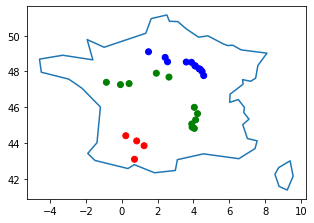

In [5]:
# On a 26 stations
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
france = world[world['name'] == "France"].geometry.explode().values[[1, 2]].unary_union()
base = gpd.GeoSeries(france).boundary.plot(figsize = (5, 5))
stations_debit.plot(ax = base, color = cours_eau_cmap(stations_debit["Cours eau"]))

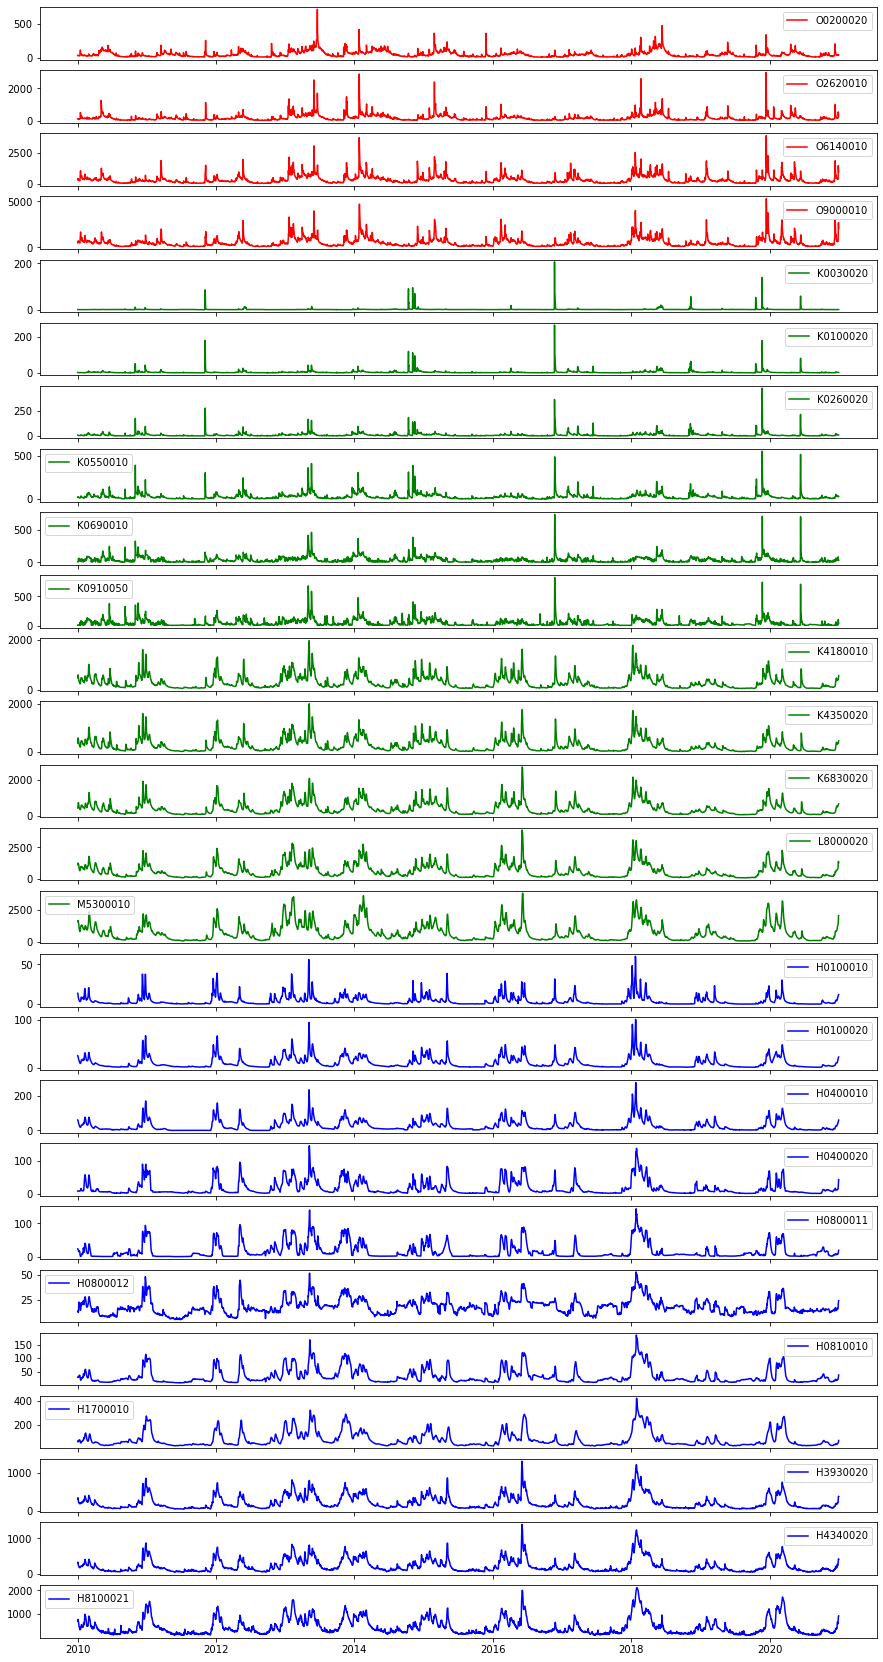

In [9]:
n_stations = stations_debit.shape[0]
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = stations_debit.iloc[i]["Code station"]
    axs[i].plot(mesures["Date"], mesures[code], label = code, 
                color = cours_eau_cmap(stations_debit.iloc[i]["Cours eau"]))
    axs[i].legend()

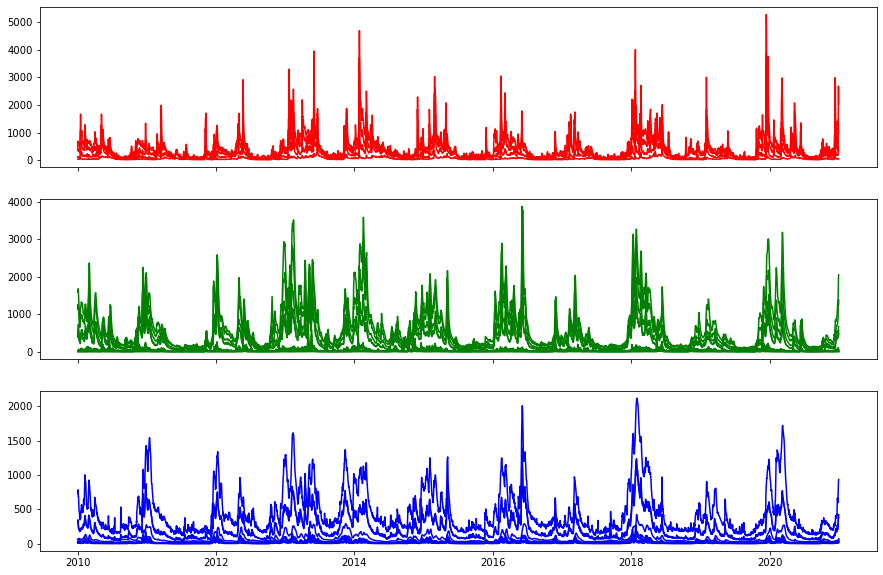

In [10]:
fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,10), sharex=True)
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == i]["Code station"])
    for code in stations:
        axs[i].plot(mesures["Date"], mesures[code],
                   color = cours_eau_cmap(i))

On regarde les distributions en fonction des fleuves.

In [11]:
# Pour chaque station, on regarde les quantiles, la moyenne, la variance, et on regarde les distrib
n_stations = stations_debit.shape[0]

stations_debit["Moyenne"] = [mesures[code].mean() for code in stations_debit["Code station"]]
stations_debit["Variance"] = [mesures[code].var() for code in stations_debit["Code station"]]

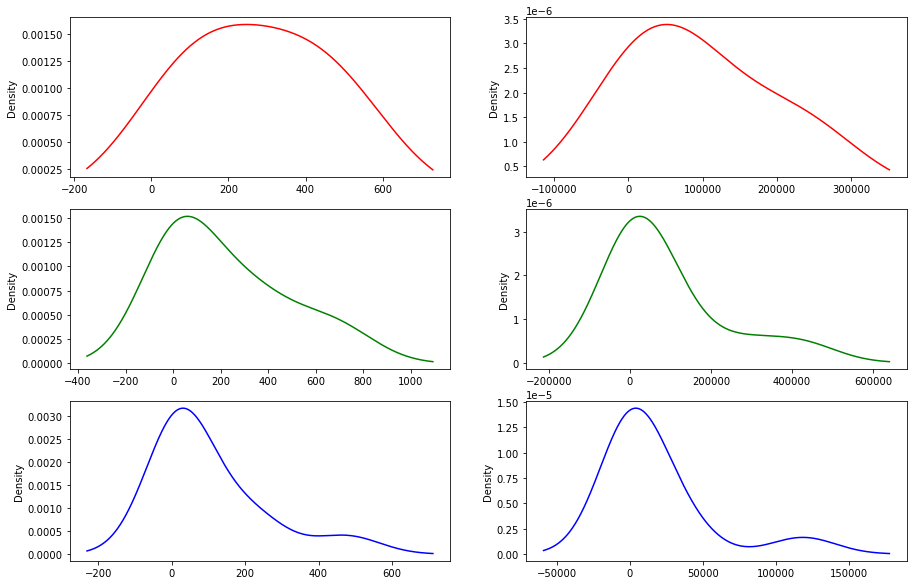

In [12]:
fig, axs = plt.subplots(n_cours_eau, 2, figsize = (15,10))
for i in range(n_cours_eau):
    stations_debit[stations_debit["Cours eau"] == i]["Moyenne"].plot.density(ax = axs[i, 0],
                   color = cours_eau_cmap(i))
    stations_debit[stations_debit["Cours eau"] == i]["Variance"].plot.density(ax = axs[i, 1],
                   color = cours_eau_cmap(i))

On regarde si la moyenne et la variance bougent significativement en fonction des mois.plot

In [13]:
for current_month in range(1,13):
    mesures_month = mesures[mesures["Date"].apply(lambda x: x.month) == current_month]
    stations_debit["Moyenne_" + str(current_month)] = [mesures_month[code].mean() for code in stations_debit["Code station"]]
    stations_debit["Variance_" + str(current_month)] = [mesures_month[code].var() for code in stations_debit["Code station"]]

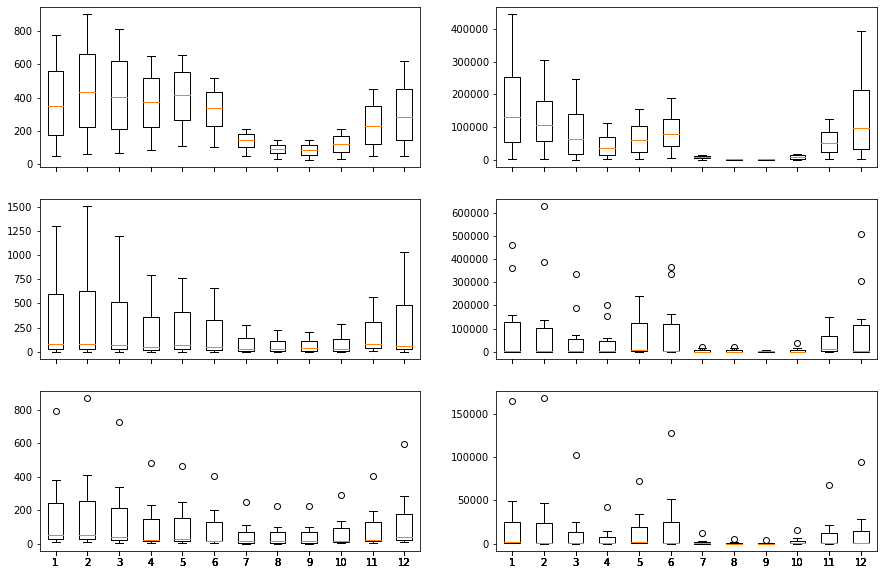

In [14]:
fig, axs = plt.subplots(n_cours_eau, 2, figsize = (15,10), sharex=True)
for i in range(n_cours_eau):
    data = []
    for current_month in range(1,13):
        data.append(list(stations_debit[stations_debit["Cours eau"] == i]["Moyenne_" + str(current_month)]))
    axs[i,0].boxplot(data)
    data = []
    for current_month in range(1,13):
        data.append(list(stations_debit[stations_debit["Cours eau"] == i]["Variance_" + str(current_month)]))
    axs[i,1].boxplot(data)

### Autocorrélations

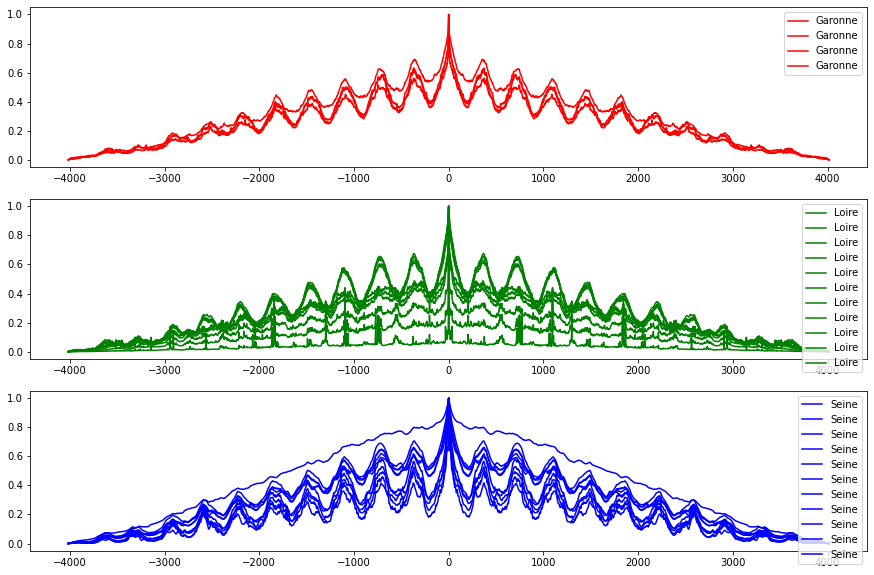

In [21]:
origine = len(mesures)-1

fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,10))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == i]["Code station"])
    for code in stations:
        corr= signal.correlate(mesures[code], mesures[code], mode = "full")
        corr /= np.max(corr)
        axs[i].plot([i-origine for i in range(len(mesures)*2-1)], corr,
                   color = cours_eau_cmap(i),
                   label = cours_eau_couleur["Cours eau"][i])
        axs[i].legend()
plt.savefig("../Data/Figures/Explorations/ACF.png")

## Desaisonnalisation
Pour regarder ce qu'il se passe, on fait une désaisonnalisation naive, en faisant la moyenne pour chaque date (jour/mois).

In [22]:
saisonnalite = pd.DataFrame({"Mois": range(1,13)})
saisonnalite = saisonnalite.merge(pd.DataFrame({"Jour": range(1,32)}), how = "cross")
saisonnalite 

,Mois,Jour
0,1,1
1,1,2
2,1,3
3,1,4
4,1,5
...,...,...
367,12,27
368,12,28
369,12,29
370,12,30


In [23]:
mesures_stations = mesures[["Date"] + list(stations_debit["Code station"])]
compo_stations = []
for curr_mois in tqdm(range(1,13)):
    mesures_mois = mesures_stations[mesures_stations["Date"].apply(lambda x: x.month == curr_mois)]
    for curr_jour in range(1,32):
        mesures_jour = mesures_mois[mesures_mois["Date"].apply(lambda x: x.day == curr_jour)]
        if len(mesures_jour)>0:
            compo = list(mesures_jour[list(stations_debit["Code station"])].mean())
            compo_stations.append(compo)
        else:
            compo = [np.nan for i in range(n_stations)]
            compo_stations.append(compo)

100%|██████████| 12/12 [00:00<00:00, 13.91it/s]


In [24]:
saisonnalite[list(stations_debit["Code station"])] = compo_stations
saisonnalite

,Mois,Jour,O0200020,O2620010,O6140010,O9000010,K0030020,K0100020,K0260020,K0550010,...,H0100020,H0400010,H0400020,H0800011,H0800012,H0810010,H1700010,H3930020,H4340020,H8100021
0,1,1,39.716667,129.365152,328.977273,526.825758,0.902652,4.379470,14.079924,39.932348,...,22.110227,56.793788,36.964470,35.848258,22.750530,53.239394,122.487879,355.335606,371.843939,805.454545
1,1,2,39.152273,127.203788,337.257576,522.840909,0.884545,4.291439,13.678864,39.123712,...,22.528864,56.450379,37.530606,37.495985,23.384773,54.673485,123.764394,354.906818,378.223485,820.507576
2,1,3,44.862879,147.056818,353.931818,556.378788,0.853258,4.018106,13.229848,38.611742,...,22.243258,55.565909,37.257652,37.799545,23.387727,56.649242,124.456818,355.832576,376.269697,816.734848
3,1,4,44.119697,151.945455,387.454545,628.340909,0.893636,4.380379,14.128636,40.485606,...,23.033106,56.323485,36.476136,38.856742,24.151212,57.817424,125.593939,354.773485,378.704545,820.924242
4,1,5,44.293939,160.872727,419.696970,686.537879,0.847500,4.032121,13.780606,40.476515,...,24.463333,58.295455,33.962727,38.382955,23.867727,58.693182,127.197727,364.709091,381.757576,814.416667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,12,27,41.706818,134.669697,343.531061,532.704545,1.062576,6.022955,16.437879,44.153030,...,23.316061,60.257803,34.319091,33.439773,23.492273,51.931061,114.356061,361.262121,385.531061,798.575758
368,12,28,46.940152,167.799242,365.687121,553.219697,1.048409,5.555152,15.857197,43.989924,...,22.914470,59.345303,32.544470,32.981667,22.938561,52.758333,118.250000,355.125000,386.027273,822.340909
369,12,29,43.960606,190.767424,489.871212,725.628788,0.995985,4.977045,15.246288,42.925000,...,22.360076,57.747652,33.341515,31.426970,22.558182,53.346970,121.212879,358.996970,382.185606,833.015152
370,12,30,41.823485,160.146212,416.439394,731.477273,0.969394,4.691061,14.154545,39.973485,...,21.851288,56.884848,34.631818,32.329773,22.860076,52.228030,122.632576,369.896212,393.471970,842.409091


In [25]:
mesures_debit_desaison = mesures[["Date"]].copy()
for code in tqdm(stations_debit["Code station"]):
    mesures_station = mesures[["Date", code]].copy()
    mesures_station["Mois"] = mesures_station["Date"].apply(lambda x: x.month)
    mesures_station["Jour"] = mesures_station["Date"].apply(lambda x: x.day)
    mesures_station = mesures_station.merge(saisonnalite[["Mois", "Jour", code]], how = "left", suffixes=(None, "_saison"),
                                            on = ["Mois", "Jour"])
    mesures_debit_desaison[code] = mesures_station[code] - mesures_station[code+"_saison"]

100%|██████████| 26/26 [00:00<00:00, 37.22it/s]


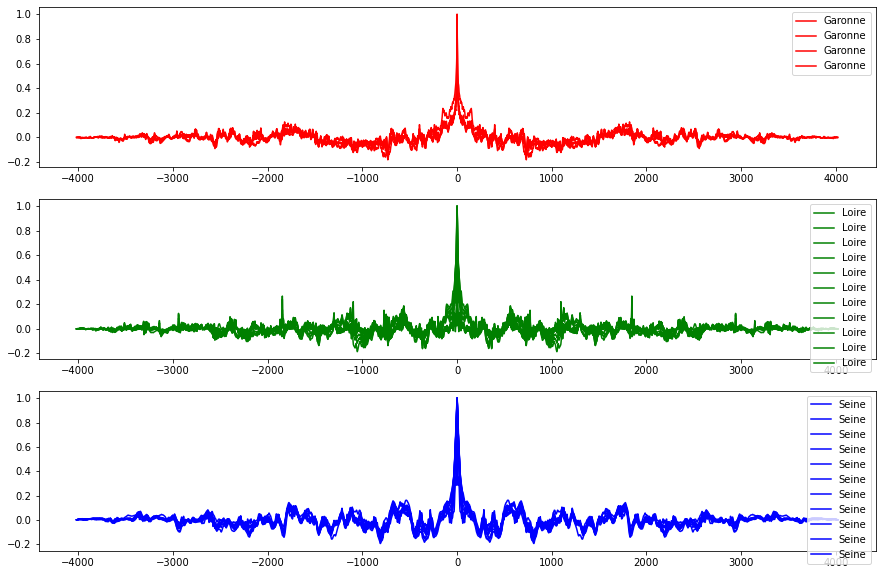

In [34]:
origine = len(mesures)-1

fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,10))
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == i]["Code station"])
    for code in stations:
        corr= signal.correlate(mesures_debit_desaison[code], mesures_debit_desaison[code], mode = "full")
        corr /= np.max(corr)
        axs[i].plot([i-origine for i in range(len(mesures_debit_desaison)*2-1)], corr,
                   color = cours_eau_cmap(i),
                    label = cours_eau_couleur["Cours eau"][i])
        axs[i].legend()
plt.savefig("../Data/Figures/Explorations/ACF_desaison.png")

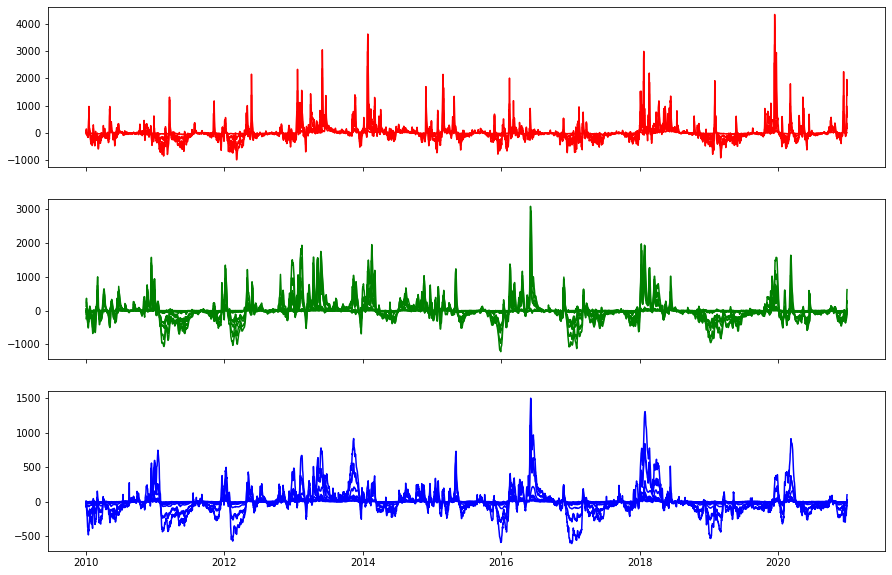

In [28]:
fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,10), sharex=True)
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == i]["Code station"])
    for code in stations:
        axs[i].plot(mesures["Date"], mesures_debit_desaison[code],
                   color = cours_eau_cmap(i))

C'est quand même mieux

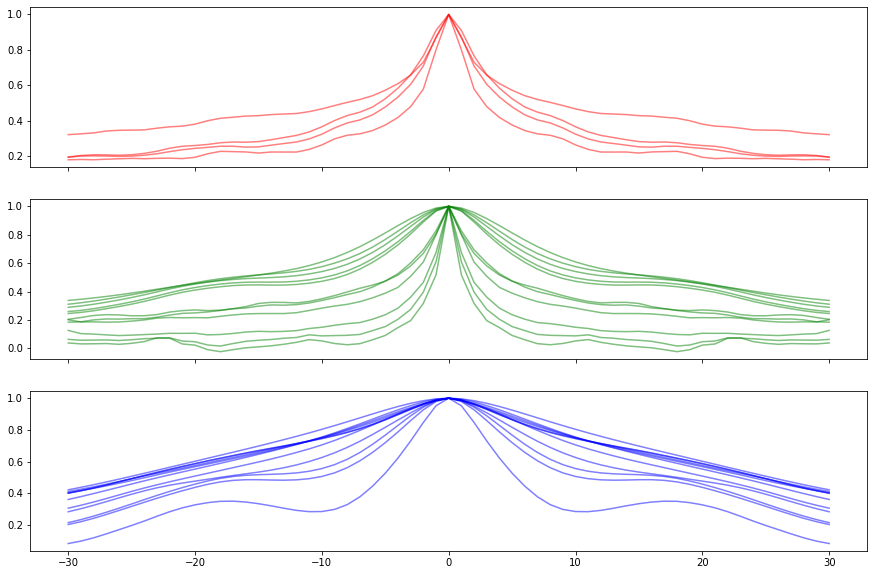

In [29]:
fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,10), sharex=True)
origine = len(mesures_debit_desaison)-1
max_lag = 30 # 1 mois
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == i]["Code station"])
    for code in stations:
        corr= signal.correlate(mesures_debit_desaison[code], mesures_debit_desaison[code], mode = "full")
        corr /= np.max(corr)
        axs[i].plot([i-max_lag for i in range(max_lag*2+1)], corr[(origine-max_lag):(origine+max_lag+1)],
                   color = cours_eau_cmap(i),
                   alpha = 0.5)

On regarde la PACF

C:\Users\zhouj\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1024: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Users\zhouj\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1024: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Users\zhouj\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1024: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Users\zhouj\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1024: FutureWarning: The default number of lags is changin

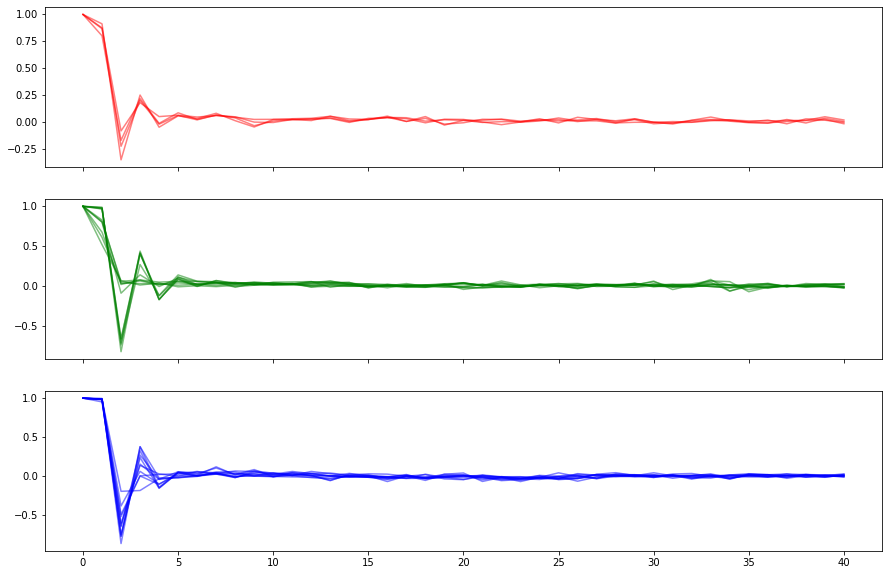

In [30]:
fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,10), sharex=True)
origine = len(mesures_debit_desaison)-1
max_lag = 30 # 1 mois
for i in range(n_cours_eau):
    stations = list(stations_debit[stations_debit["Cours eau"] == i]["Code station"])
    for code in stations:
        corr= pacf(mesures_debit_desaison[code], method = "ols-adjusted")
        axs[i].plot(corr,
                   color = cours_eau_cmap(i),
                   alpha = 0.5)

Correlation croisées

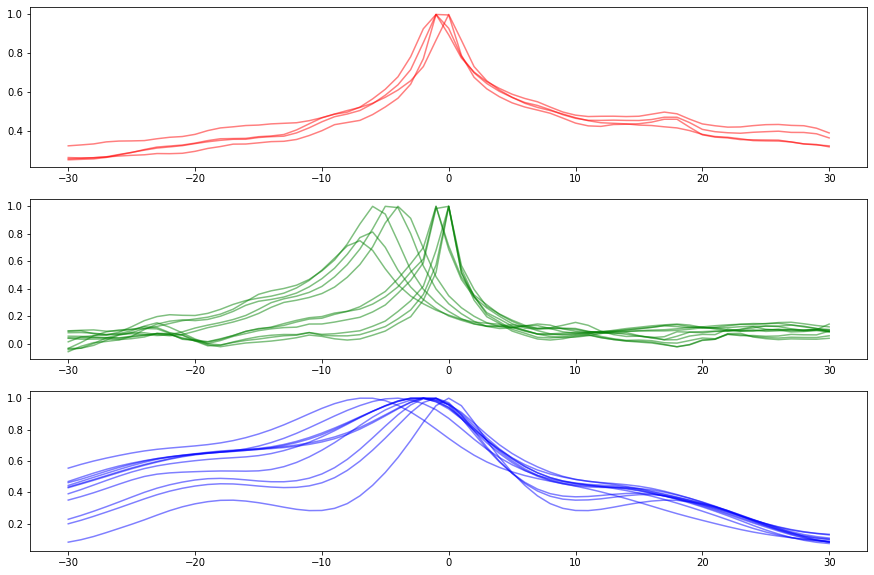

In [33]:
fig, axs = plt.subplots(n_cours_eau, 1, figsize = (15,10))
origine = len(mesures_debit_desaison)-1
max_lag = 30 # 1 mois

for i in range(n_cours_eau):
    station_amont = stations_debit[(stations_debit["Cours eau"] == i) & (stations_debit["Ordre"] == 0)]["Code station"].values[0]
    stations = list(stations_debit[stations_debit["Cours eau"] == i]["Code station"])
    for code in stations:
        corr= signal.correlate(mesures_debit_desaison[station_amont], mesures_debit_desaison[code], mode = "full")
        corr /= np.max(corr)
        axs[i].plot([i-max_lag for i in range(max_lag*2+1)], corr[(origine-max_lag):(origine+max_lag+1)],
                   color = cours_eau_cmap(i),
                   alpha = 0.5)
plt.savefig("../Data/Figures/Explorations/ACC.png")

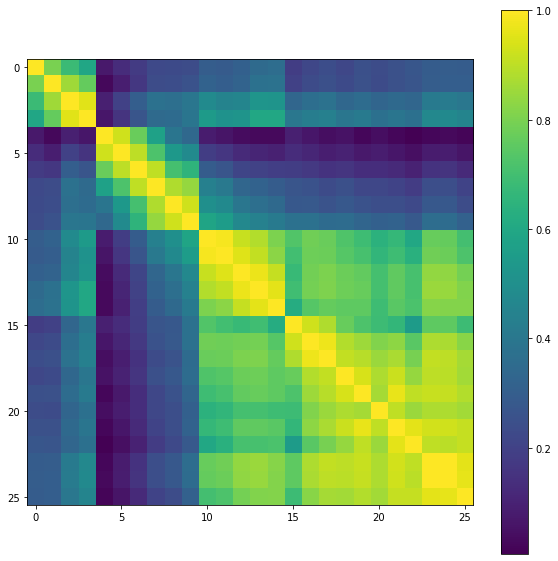

In [22]:
fig, ax = plt.subplots(figsize = (10, 10))
im = ax.imshow(mesures_debit_desaison.corr())
fig.colorbar(im)

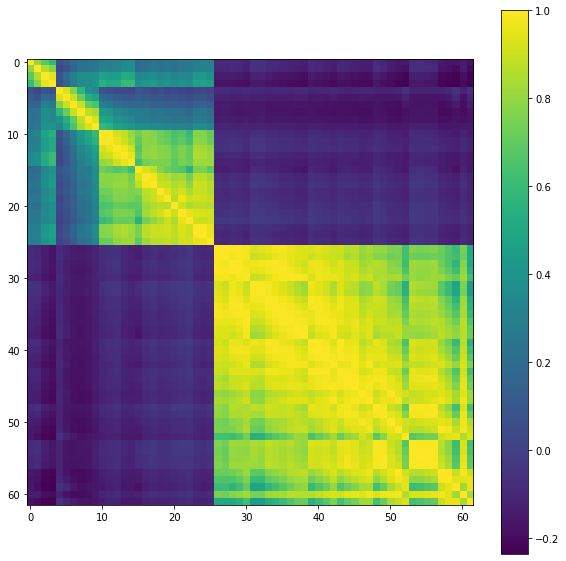

In [23]:
mesures_debit_desaison_pression = mesures_debit_desaison.merge(mesures.filter(regex="Date|Pression.*"))
fig, ax = plt.subplots(figsize = (10, 10))
im = ax.imshow(mesures_debit_desaison_pression.corr())
fig.colorbar(im)

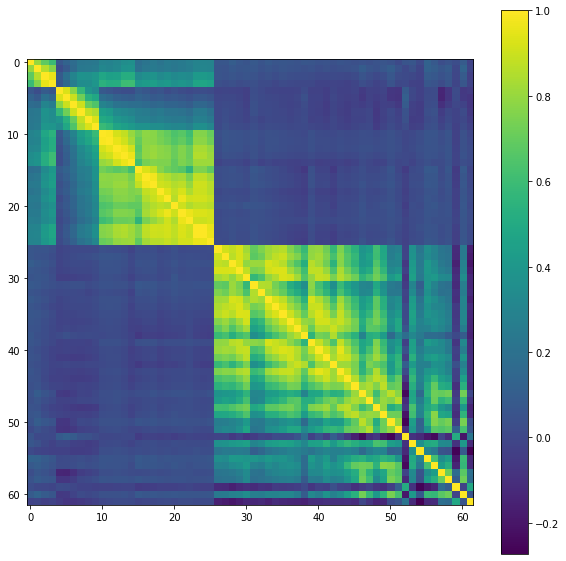

In [24]:
mesures_debit_desaison_direction_vent = mesures_debit_desaison.merge(mesures.filter(regex="Date|Vent_Nord.*"))
fig, ax = plt.subplots(figsize = (10, 10))
im = ax.imshow(mesures_debit_desaison_direction_vent.corr())
fig.colorbar(im)

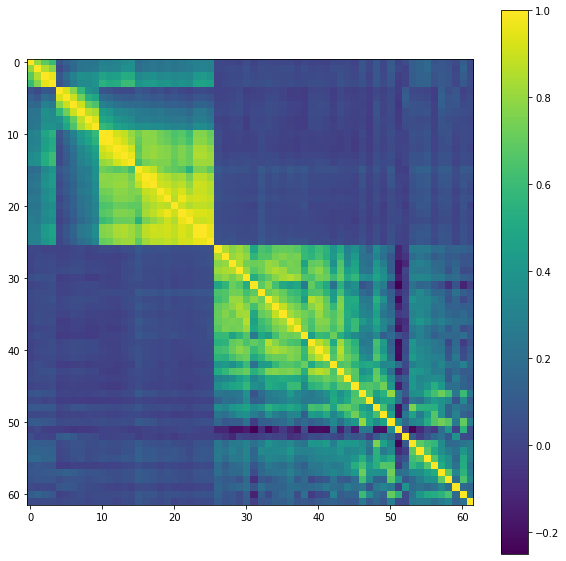

In [25]:
mesures_debit_desaison_vitesse_vent = mesures_debit_desaison.merge(mesures.filter(regex="Date|Vitesse_vent.*"))
fig, ax = plt.subplots(figsize = (10, 10))
im = ax.imshow(mesures_debit_desaison_vitesse_vent.corr())
fig.colorbar(im)

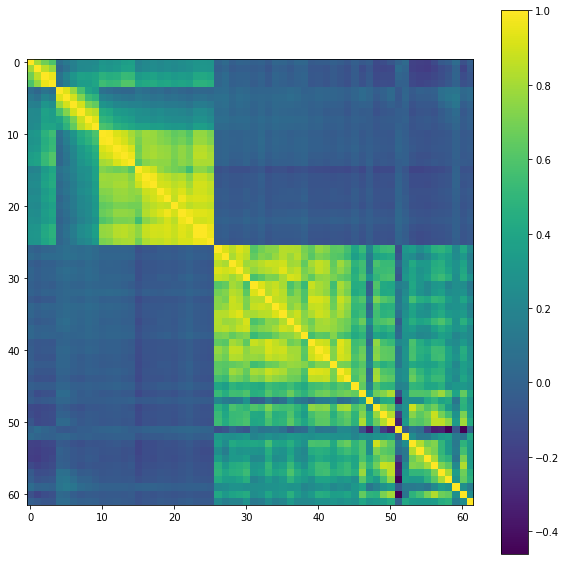

In [26]:
mesures_debit_desaison_direction_vent = mesures_debit_desaison.merge(mesures.filter(regex="Date|Vent_Est.*"))
fig, ax = plt.subplots(figsize = (10, 10))
im = ax.imshow(mesures_debit_desaison_direction_vent.corr())
fig.colorbar(im)

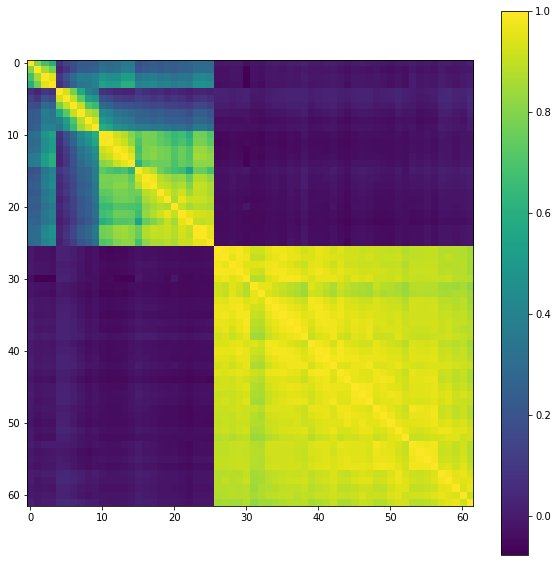

In [27]:
mesures_debit_desaison_temperature = mesures_debit_desaison.merge(mesures.filter(regex="Date|Temperature.*"))
fig, ax = plt.subplots(figsize = (10, 10))
im = ax.imshow(mesures_debit_desaison_temperature.corr())
fig.colorbar(im)

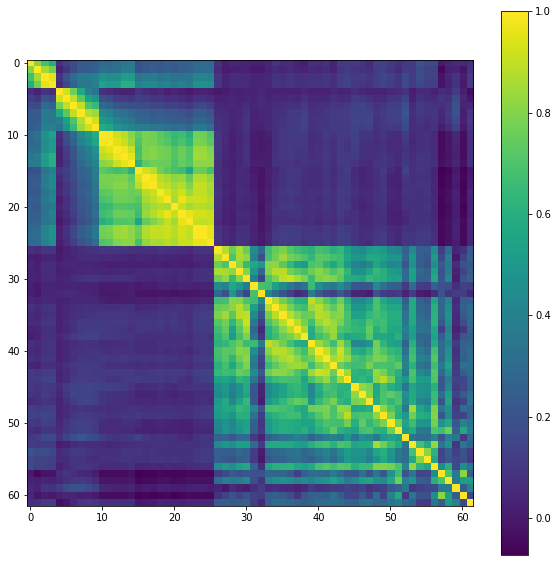

In [28]:
mesures_debit_desaison_humidite = mesures_debit_desaison.merge(mesures.filter(regex="Date|Humidite.*"))
fig, ax = plt.subplots(figsize = (10, 10))
im = ax.imshow(mesures_debit_desaison_humidite.corr())
fig.colorbar(im)

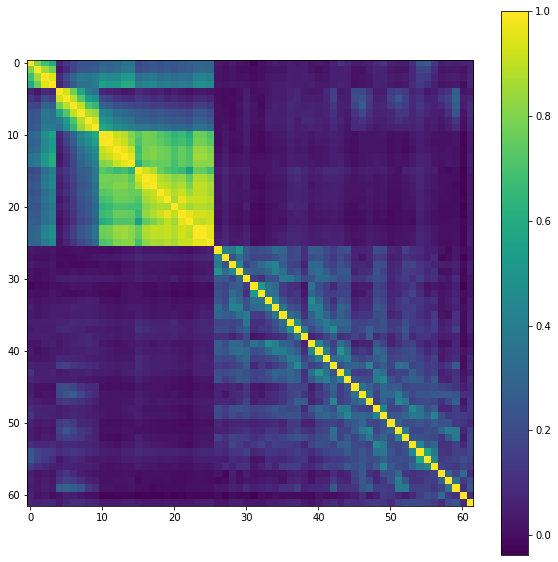

In [29]:
mesures_debit_desaison_precipitations = mesures_debit_desaison.merge(mesures.filter(regex="Date|Precipitations.*"))
fig, ax = plt.subplots(figsize = (10, 10))
im = ax.imshow(mesures_debit_desaison_precipitations.corr())
fig.colorbar(im)